# Lab exercise 6: The Variational Auto-Encoder
The VAE that we will develop is based on the following generative story:
* $z\sim p_\theta(z)$
* $x \sim p_\theta(x|z;θ)$

where the latent representations z take value in $R^n$
. The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent. We fix the mean and variance of each coordinate to 0 and 1, respectively. The conditional distribution $p(x|z;θ)$ is parameterized by a neural network: it is the decoder! The generated pixels x are independent Gaussians with a fixed variance.

Note: this kind of VAE will be quite bad at generating MNIST picture. Therefore, when you do you experiments, you should both generate picture and display the mean parameters of the output distributions. This is a well known problem of VAE, you can try to play with the network architecture and the parameters to improve generation.

Although the decoder is similar to the auto-encoder decoder, the encoder is different: it must return two tensors, the tensor of means and the tensor of variances. As the variance of a Gaussian distribution is constrained to be strictly positive, it is usual to instead return the log-variance (or log squared variance), which is unconstrained. If you exponentiate the log-variance, you get the variance which will be strictly positive as the exponential function only returns positive values.

Similarly to the auto-encoder, there are several hyperparameters you can try to tune. However, for the VAE I strongly advise you to:
* set the latent space dim to 2
* use [gradient clipping](https://pytorch-org.translate.goog/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html?_x_tr_sl=en&_x_tr_tl=fr&_x_tr_hl=fr&_x_tr_pto=sc) (bound the gradient) 


In [1]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [2]:
class VAEEncoder(nn.Module):
    def __init__(self, dim_input, dim_latent):
        super().__init__()
        self.fc1 = nn.Linear(dim_input, 256)
        self.fc_mu = nn.Linear(256, dim_latent)
        self.fc_log_sigma_squared = nn.Linear(256, dim_latent)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.fc1(inputs))
        mu = self.fc_mu(x)
        log_sigma_squared = self.fc_log_sigma_squared(x)
        return mu, log_sigma_squared
        
class VAEDecoder(nn.Module):
    def __init__(self, dim_latent, dim_output):
        super().__init__()
        self.fc1 = nn.Linear(dim_latent, 256)
        self.fc2 = nn.Linear(256, dim_output)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        img = self.sigmoid(self.fc2(x))
        return img

To compute the training loss, you must compute two terms:
* A Monte-Carlo estimation of the reconstruction loss (you can start considering sampling only one z)
* The KL divergence between the distributions computed by the encoder and the prior

For the reconstruction loss, you can use the mean square error loss.

To sample values, you can use the reparameterization trick as follows: 
```
e = torch.normal(0, 1., mu.shape)
z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))
```

For the formula of the $KL(q_\phi(z|x)|| p_\theta(z))$ you should have it from the exercise we did during the lecture. You can also check appendix of the [original paper](https://arxiv.org/pdf/1312.6114.pdf) 

You have in the following to implements:
* The training loop
* The two losses
* Choose which architecture for encoder and decoder

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def KL(mu, log_sigma_squared):
    kl_div_per_sample = -0.5 * torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp(), dim=1)
    mean_kl_div = torch.mean(kl_div_per_sample)
    return mean_kl_div

def reconstruction_loss(input_image, predicted_image_params, per_pixel=False):
    batch_size = input_image.size(0)
    loss_sum_per_image = F.mse_loss(predicted_image_params, input_image.to(device), reduction='none').sum(dim=1)
    mean_loss = loss_sum_per_image.mean()
    return mean_loss

last_mu = None
last_log_sigma = None
    
def training_loop(dataset, encoder, decoder, n_sample_monte_carlo=1, max_epoch=50, learning_rate=1e-3, batch_size=128, max_grad_norm=5e-1):
    global last_mu, last_log_sigma
    
    encoder.to(device)
    decoder.to(device)

    processed_dataset = [torch.tensor(img, dtype=torch.float32) for img in dataset]
    data_loader = DataLoader(processed_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(params, lr=learning_rate)

    for epoch in range(max_epoch):
        losses = []
        encoder.train()
        decoder.train()
        for x in data_loader:
            x = x.to(device)

            optimizer.zero_grad()

            mu, log_sigma_squared = encoder(x)

            batch_recon_loss = 0.0
            for _ in range(n_sample_monte_carlo):
                e = torch.randn_like(mu, device=device)
                std = torch.exp(0.5 * log_sigma_squared)
                z = mu + e * std
                y_params = decoder(z)
                batch_recon_loss += reconstruction_loss(x, y_params)

            avg_batch_recon_loss = batch_recon_loss / n_sample_monte_carlo

            kl_loss = KL(mu, log_sigma_squared)
            loss = avg_batch_recon_loss + kl_loss

            losses.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(params, max_grad_norm)
            optimizer.step()
        print(f"The sum of losses for epoch {epoch} is {np.sum(losses)}")

In [4]:
import dataset_loader # file given in lab 3
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"


train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

dataset = train_data[0]

dim_input = dataset.shape[1]
dim_latent = 2
dim_output = dim_input

encoder = VAEEncoder(dim_input=dim_input, dim_latent=dim_latent)
decoder = VAEDecoder(dim_latent=dim_latent, dim_output=dim_output)

training_loop(dataset, encoder, decoder,
              n_sample_monte_carlo=1,
              max_epoch=20,   
              learning_rate=1e-3,
              batch_size=128,
              max_grad_norm=0.5)

The sum of losses for epoch 0 is 19504.41851043701
The sum of losses for epoch 1 is 16614.209800720215
The sum of losses for epoch 2 is 16154.463249206543
The sum of losses for epoch 3 is 15862.75675201416
The sum of losses for epoch 4 is 15671.170524597168
The sum of losses for epoch 5 is 15532.216423034668
The sum of losses for epoch 6 is 15419.002868652344
The sum of losses for epoch 7 is 15329.29010772705
The sum of losses for epoch 8 is 15256.349712371826
The sum of losses for epoch 9 is 15192.983554840088
The sum of losses for epoch 10 is 15138.073234558105
The sum of losses for epoch 11 is 15090.126056671143
The sum of losses for epoch 12 is 15043.382320404053
The sum of losses for epoch 13 is 15005.764797210693
The sum of losses for epoch 14 is 14970.776866912842
The sum of losses for epoch 15 is 14925.814834594727
The sum of losses for epoch 16 is 14890.962100982666
The sum of losses for epoch 17 is 14856.130638122559
The sum of losses for epoch 18 is 14830.714805603027
The su

## Generating new images

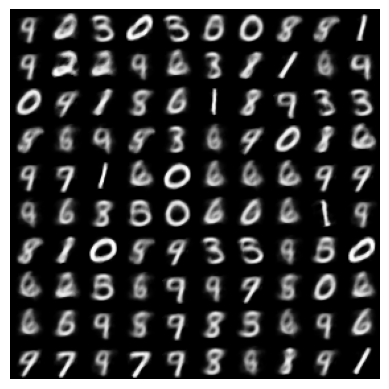

In [5]:
encoder.eval()
decoder.eval()

n = 10

if last_mu is None:
    z = torch.randn(n * n, dim_latent, device=device)
else:
    z = torch.normal(0, 1., size=(n*n, dim_latent), device=device)

with torch.no_grad():
    generated = decoder(z)

imgs = np.zeros((n*28, n*28))

plt.figure()
for i in range(n*n):
    if i < generated.shape[0]:
        row = i // n
        col = i % n
        imgs[row * 28 : row * 28 + 28, col * 28 : col * 28 + 28] = 1 - generated[i].detach().cpu().numpy().reshape(28,28)
    else:
        break

plt.axis('off')
plt.imshow(imgs, cmap='Greys')

## Latent space visualization

It is quite useful to visualize the latent space the variational auto-encoder. You can visualize it either for the training data or the dev data. Note that if you want to visualize a latent space when its dimension is greater than two (useful for the first part!), you could project it in 2 dimensions using PCA (its already implemented in scikit-learn!) 

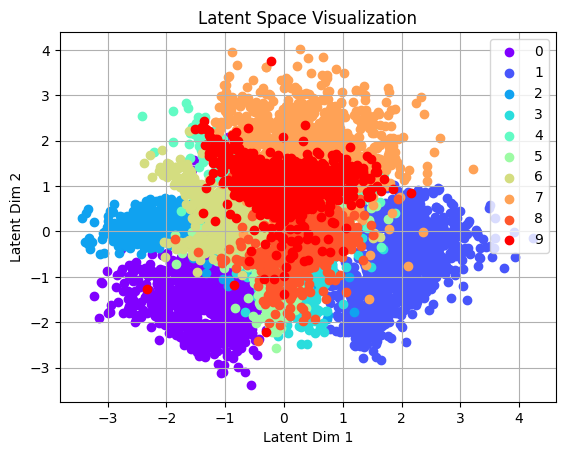

In [6]:
import matplotlib.cm as cm

dev_images_np = np.array(dev_data[0])
dev_labels_np = np.array(dev_data[1])

dev_dataset_tuples = list(zip([torch.tensor(img, dtype=torch.float32) for img in dev_images_np],
                              [torch.tensor(label, dtype=torch.long) for label in dev_labels_np]))
dl = DataLoader(dev_dataset_tuples, batch_size=128, shuffle=True, drop_last=True)

az = []
ay = []

encoder.eval()
with torch.no_grad():
    for x, y in dl:
        x = x.to(device)
        mu, log_sigma = encoder(x)

        z = torch.randn(mu.shape, device=device) * torch.exp(0.5 * log_sigma) + mu

        az += z.cpu().tolist()
        ay += y.tolist()
        
az = np.array(az)
ay = np.array(ay)

plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    indices = (ay == i)
    if np.any(indices):
      plt.scatter(az[ay == i][:, 0], az[ay == i][:, 1], color=colors[i])

plt.title("Latent Space Visualization")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.legend([str(i) for i in range(10)])
plt.grid(True)
plt.show()